# Hyperparameters

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import scipy.stats as stats
import time

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.colors as plotly_colors
import plotly.figure_factory as ff
from plotly.io import renderers
renderers.default = 'png'

from utils.design import plotly_main_layout, plotly_main_subplot_layout

___
### Data Normalization

In [2]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=';')

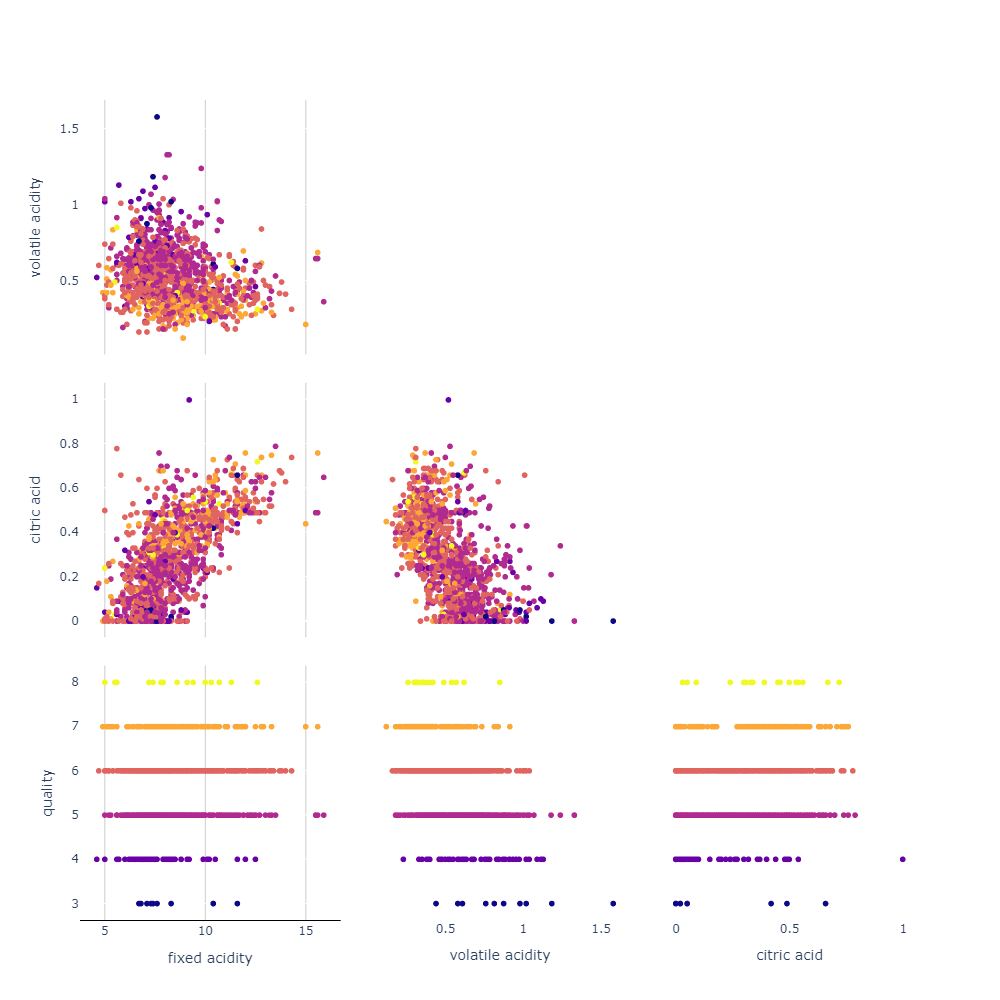

In [3]:
fig = go.Figure()
fig.add_trace(go.Splom(
    dimensions=[
        dict(label="fixed acidity", values=data["fixed acidity"]),
        dict(label="volatile acidity", values=data["volatile acidity"]),
        dict(label="citric acid", values=data["citric acid"]),
        dict(label="quality", values=data["quality"]),
    ],
    marker=dict(color=data['quality'], showscale=False,),
    diagonal=dict(visible=False), showupperhalf=False,
))
plotly_main_layout(fig, width=1000, height=1000, x='fixed acidity',)

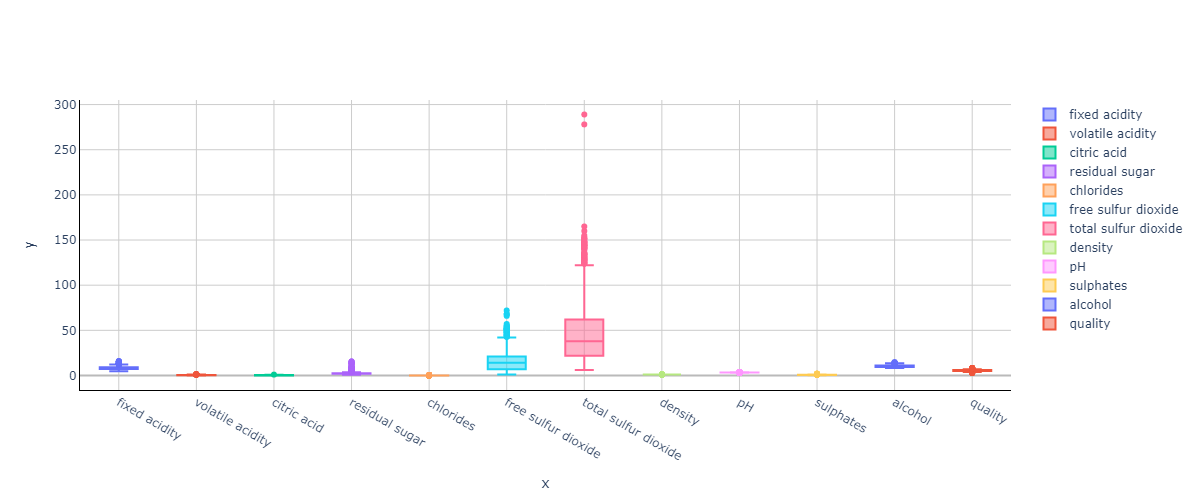

In [4]:
fig = go.Figure()
for column in data.columns:
    fig.add_trace(go.Box(
        y=data[column], name=column, boxpoints='outliers'
    ))
fig.update_layout(
    width=1700, height=400, xaxis_tickangle=45
)
plotly_main_layout(fig, width=1200, height=500)

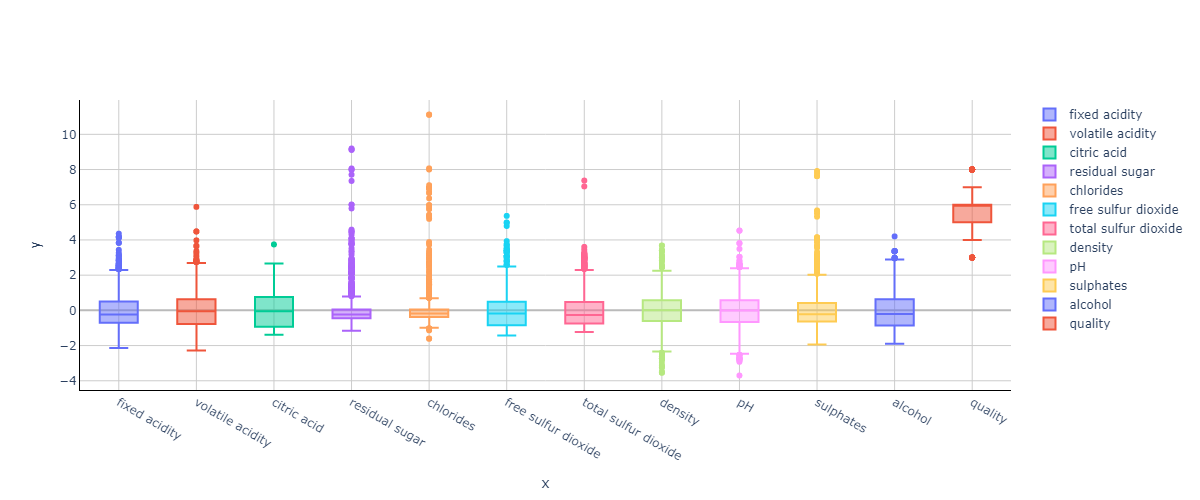

In [5]:
for col in [col for col in data.columns if col != 'quality']:
    data[col] = stats.zscore(data[col])
fig = go.Figure()
for column in data.columns:
    fig.add_trace(go.Box(
        y=data[column], name=column, boxpoints='outliers'
    ))
fig.update_layout(
    width=1700, height=400, xaxis_tickangle=45
)
plotly_main_layout(fig, width=1200, height=500)

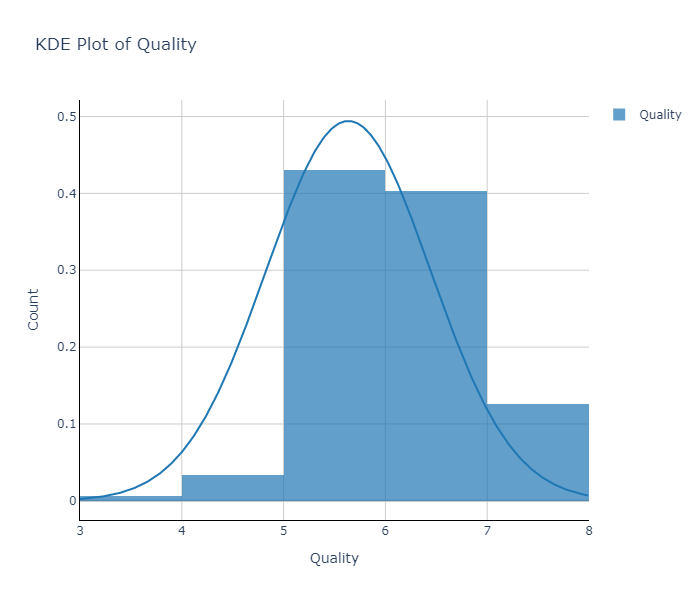

In [6]:
fig = ff.create_distplot([data['quality']], ['Quality'], show_hist=True, show_rug=False, curve_type='normal')
plotly_main_layout(fig, title='KDE Plot of Quality', x='Quality', y='Count')
fig.show()

data['boolQuality'] = 0
data['boolQuality'] = data['quality'].apply(lambda x: 1 if x > 5 else 0)

In [7]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor(data[[col for col in data.columns if column not in ['quality', 'boolQuality']]].values).float()
labels = torch.tensor(data['boolQuality'].values).float()

# we'll actually need the labels to be a "tensor"
labels = labels[:,None]
print('Label Shape:')
print(labels.shape, '\n')
     
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

train_data = TensorDataset(train_data, train_labels)
test_data  = TensorDataset(test_data, test_labels)

batchsize    = 64
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])
     
print('Loader Shape:')
for X,y in train_loader:
  print(X.shape,y.shape)

Label Shape:
torch.Size([1599, 1]) 

Loader Shape:
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])
torch.Size([64, 0]) torch.Size([64, 1])


___
### Normalization

- Motivation: 
    - $\hat{y} = \sigma(\textbf{x}^\text{T}\textbf{w})$
    - $\textbf{w} \leftarrow \textbf{w} - \eta d\mathcal{L}$
- Z-Transform:
    - $z_i = \dfrac{x_i - \bar{x}}{\sigma}$
- Min-Max:
    - $\tilde{x} = \dfrac{x - \text{min }x}{\text{max }x - \text{min }x}$
    - $x^* = a + \tilde{x}(b-a)$
> ##### Batch (Layer) Normalization
> - It is the processos of normalizing inputs of each deep layer, not only the input one
>    - This avoid covariance shifts (shifts of the activation distributions characteristics), and gradients vanishing or exploding
>    - $\tilde{\textbf{x}} = \gamma \textbf{x} + \beta$
>    - $\hat{y} = \sigma(\tilde{\textbf{x}}^\text{T}\textbf{w})$
>        - $\gamma$: scaling parameter
>        - $\beta$: shifting parameter
> - It should be switched off during test/evaluation, because the batch size can differ
    

###### _______________________
#### Z-Transform

In [8]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')
data = data[data['total sulfur dioxide'] < 200] # drop a few outliers

cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data.loc[:,cols2zscore] = data[cols2zscore].apply(stats.zscore)

data.loc[:,'boolQuality'] = 0
data.loc[data['quality'] > 5,'boolQuality'] = 1

In [9]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor(data[cols2zscore].values).float()
labels = torch.tensor(data['boolQuality'].values).float()
labels = labels[:, None] # transform to matrix
     
# use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = TensorDataset(train_data, train_labels)
test_dataDataset  = TensorDataset(test_data, test_labels)

In [10]:
class ANNwine(nn.Module):
    def __init__(self):
        super().__init__()

        ### input layer
        self.input = nn.Linear(11,16)

        ### hidden layers
        self.fc1 = nn.Linear(16,32)
        self.fc2 = nn.Linear(32,32)

        ### output layer
        self.output = nn.Linear(32,1)

    # forward pass
    def forward(self,x):
        x = F.relu(self.input(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.output(x)

In [11]:
def trainTheModel(numepochs=1000):

    # loss function and optimizer
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(winenet.parameters(), lr=.01)

    # initialize losses
    losses   = torch.zeros(numepochs)
    trainAcc = []
    testAcc  = []

    # loop over epochs
    for epochi in range(numepochs):

        # switch on training mode
        winenet.train()

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
        for X,y in train_loader:

            # forward pass and loss
            yHat = winenet(X)
            loss = lossfun(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute training accuracy for this batch
            batchAcc.append(100*torch.mean(((yHat > 0) == y).float()).item())

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        winenet.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad(): # deactivates autograd
            yHat = winenet(X)
        testAcc.append(100*torch.mean(((yHat>0) == y).float()).item())
      
    # function output
    return trainAcc,testAcc,losses

In [12]:
numepochs = 800

# range of batch sizes
batchsizes = 2**np.arange(1,10,2)

# initialize output results matrices
accuracyResultsTrain = np.zeros((numepochs, len(batchsizes)))
accuracyResultsTest  = np.zeros((numepochs, len(batchsizes)))
comptime             = np.zeros(len(batchsizes))

# test data doesn't vary by training batch size
test_loader = DataLoader(test_dataDataset, batch_size=test_dataDataset.tensors[0].shape[0])

# loop over batch sizes
for bi in range(len(batchsizes)):

    # start the clock!
    starttime = time.process_time()

    # create dataloader object
    train_loader = DataLoader(train_dataDataset, batch_size=int(batchsizes[bi]), shuffle=True, drop_last=True)

    # create and train a model
    winenet = ANNwine()
    trainAcc, testAcc, losses = trainTheModel(numepochs)

    # store data
    accuracyResultsTrain[:,bi] = trainAcc
    accuracyResultsTest[:,bi]  = testAcc

    # check the timer
    comptime[bi] = time.process_time() - starttime

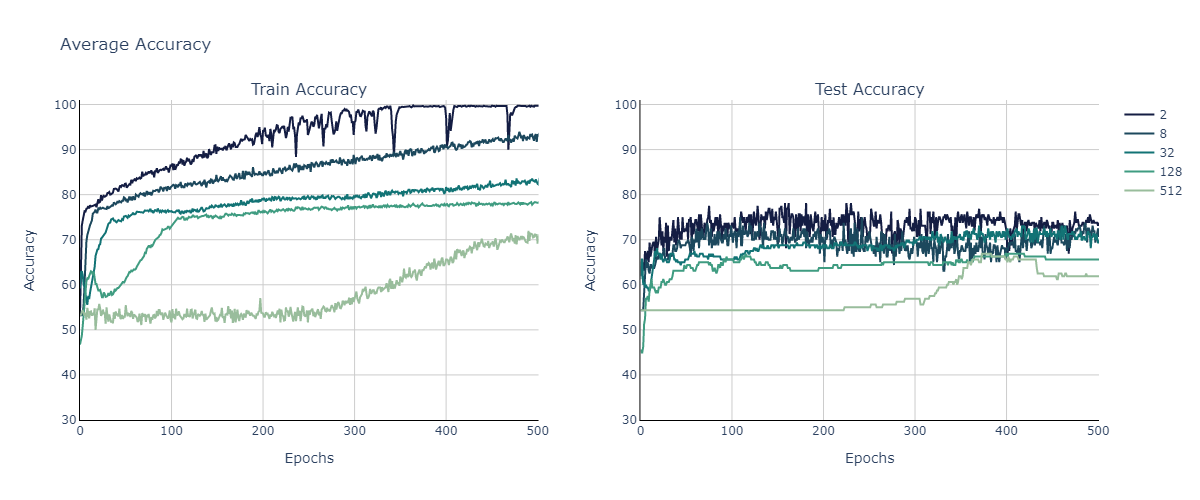

In [13]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['Train Accuracy', 'Test Accuracy'])

colors = plotly_colors.cmocean.curl[:len(batchsizes)]

for i, (acc_label, color) in enumerate(zip(batchsizes, colors)):
    fig.add_trace(go.Scatter(
        x=list(range(numepochs)), y=accuracyResultsTrain[:, i], 
        name=f'{acc_label}', mode='lines', line=dict(color=color)
    ), row=1, col=1)

# Plot Test Accuracy using same colors
for i, (acc_label, color) in enumerate(zip(batchsizes, colors)):
    fig.add_trace(go.Scatter(
        x=list(range(numepochs)), y=accuracyResultsTest[:, i], 
        name=f'{acc_label}', mode='lines',line=dict(color=color), showlegend=False  
    ), row=1, col=2)

plotly_main_subplot_layout(fig, title='Average Accuracy', x='Epochs', y='Accuracy', width=1200, height=500, x_range=[0, 501], y_range=[30, 101])

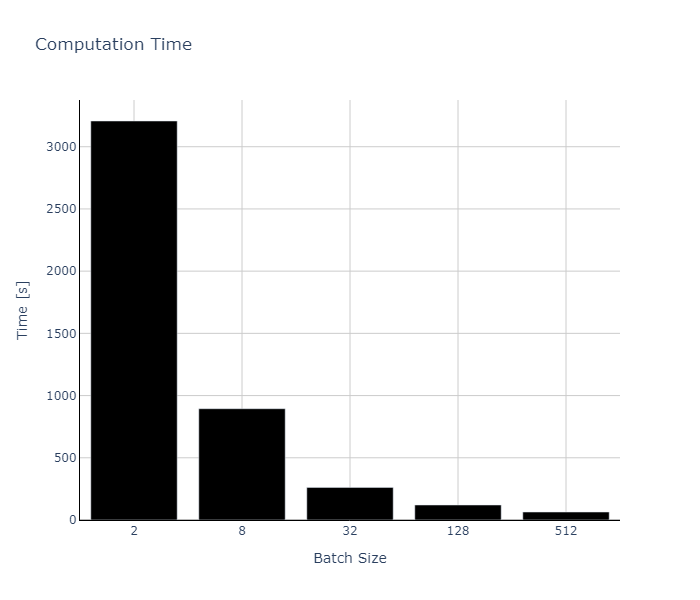

In [14]:
fig = go.Figure()
fig.add_trace(go.Bar(
    x=[str(i) for i in batchsizes], y=comptime, marker=dict(color='black')
))
plotly_main_layout(fig, title='Computation Time', x='Batch Size', y='Time [s]')

###### _______________________
#### Batch Normalization

In [15]:
class ANNwine_BatchNorm(nn.Module):
    def __init__(self):
        super().__init__()

        self.input = nn.Linear(11, 16)
        self.batch_norm1 = nn.BatchNorm1d(16)
        self.fc1 = nn.Linear(16, 32)
        self.batch_norm2 = nn.BatchNorm1d(32)
        self.fc2 = nn.Linear(32, 20)
        self.output = nn.Linear(20, 1)


    def forward(self, x, doBatchNorm):
        x = F.relu(self.input(x))

        if doBatchNorm:
            x = self.batch_norm1(x)
            x = F.relu(self.fc1(x))
            x = self.batch_norm2(x)
            x = F.relu(self.fc2(x))
        else:
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))

        x = self.output(x)
        return x

In [16]:
def trainTheModel(numepochs:int=1000, doBatchNorm:bool=True):
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(winenet.parameters(), lr=0.01)

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):
        winenet.train()
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:
            yHat = winenet(X, doBatchNorm)
            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append(100*torch.mean(((yHat > 0) == y).float()).item())

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        winenet.eval()
        X, y = next(iter(test_loader)) 
        with torch.no_grad():
            yHat = winenet(X, doBatchNorm)
        testAcc.append(100*torch.mean(((yHat > 0) == y).float()).item())
  
    # function output
    return trainAcc, testAcc, losses

In [17]:
winenet = ANNwine_BatchNorm()
trainAccNo, testAccNo, lossesNo = trainTheModel(doBatchNorm=False)

winenet = ANNwine_BatchNorm()
trainAccYes, testAccYes, lossesYes = trainTheModel(doBatchNorm=True)

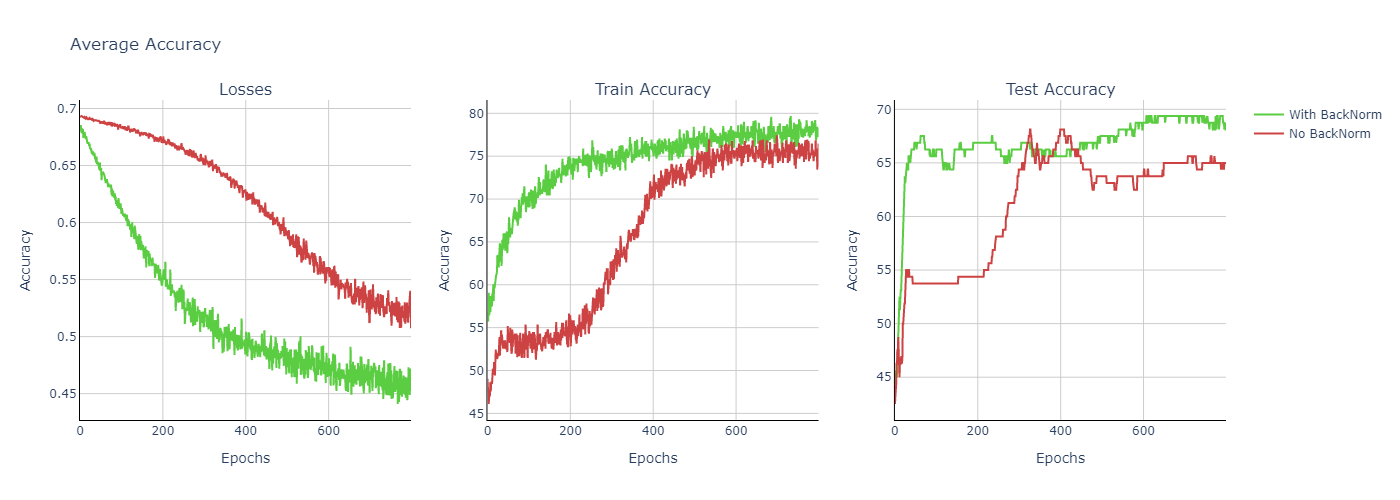

In [18]:
fig = make_subplots(rows=1, cols=3, subplot_titles=['Losses', 'Train Accuracy', 'Test Accuracy'])

fig.add_trace(go.Scatter(
    x=list(range(numepochs)), y=lossesYes, 
    name=f'With BackNorm', mode='lines', line=dict(color='#5bcd42')
), row=1, col=1)
fig.add_trace(go.Scatter(
    x=list(range(numepochs)), y=lossesNo, 
    name=f'No BackNorm', mode='lines',line=dict(color='#cd4242')
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=list(range(numepochs)), y=trainAccYes, mode='lines', line=dict(color='#5bcd42'), showlegend=False
), row=1, col=2)
fig.add_trace(go.Scatter(
    x=list(range(numepochs)), y=trainAccNo, mode='lines',line=dict(color='#cd4242'), showlegend=False
), row=1, col=2)

fig.add_trace(go.Scatter(
    x=list(range(numepochs)), y=testAccYes, mode='lines', line=dict(color='#5bcd42'), showlegend=False
), row=1, col=3)
fig.add_trace(go.Scatter(
    x=list(range(numepochs)), y=testAccNo, mode='lines',line=dict(color='#cd4242'), showlegend=False
), row=1, col=3)

plotly_main_subplot_layout(fig, title='Average Accuracy', x='Epochs', y='Accuracy', width=1400, height=500,)

___
### Activation Functions

- All deep learning model can be reduced to a linear regression without activation functions
> ##### ReLU
> - $\sigma(x) = \max(0,x)$
> - Characteristics:
>     - Strongly nonlinear
>     - Never saturates
>     - Biased average
>     - Great for Hidden
> - Hidden Layers:
>     - Nonlinearities
>     - Necessity for computational simplicity
>     - Avoiding limited ranges
>     - Avoid gradient vanishing and explosion
> - Output Layers:
>     - Nonlinear (classify) and Linear (regression)
>     - Boundaries of saturations that can be converted to probabilities

> ##### Leaky ReLU
> - $\sigma(x) = \max(ax,x), \quad (\text{tipical } \alpha=0.1)$
> - Characteristics:
>     - Strongly nonlinear
>     - Never saturates
>     - Less bias average
>     - Allows negative activations

> ##### Leaky-N
> - $\sigma(x) = \min(N,\max(0,x)), \quad (\text{tipical } N=6)$
> - Characteristics:
>     - Strongly nonlinear
>     - Saturates
>     - Avoids blowing up

> ##### Sigmoid
> - $\sigma(x) = \dfrac{1}{1+e^{-x}}$
> - Characteristics:
>     - Nearly linear
>     - Saturates at [0, 1]
>     - Biased average ($\mu = 0.5$)
>     - Great for Ouput

> ##### Tanh
> - $\sigma(x) = \dfrac{e^{x}-e^{-x}}{e^{x}+e^{-x}}$
> - Characteristics:
>     - Nearly linear in range
>     - Saturates at [-1, 1]
>     - Unbiased average
>     - Ok for Ouput

In [19]:
x = torch.linspace(-3, 3, 101)

def NNoutputx(actfun):
    actfun = getattr(torch.nn, actfun)
    return actfun()

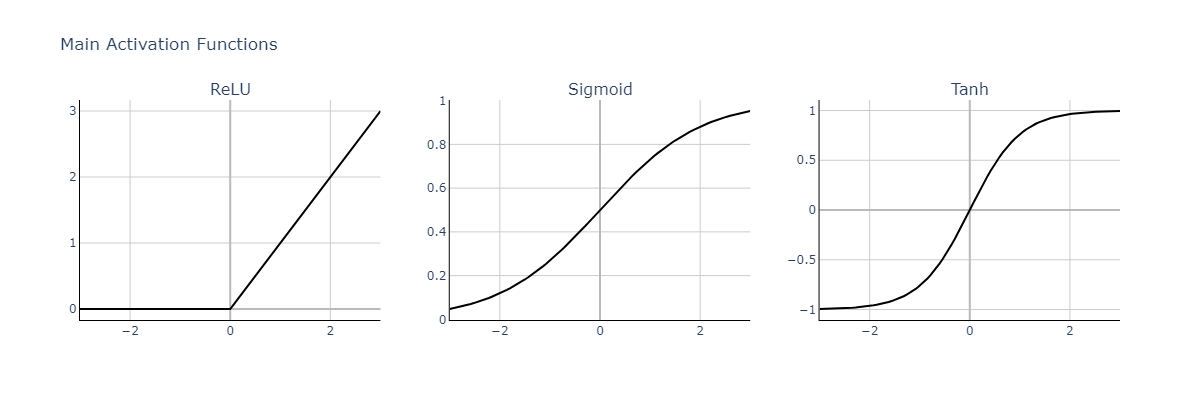

In [20]:
actfun = ['ReLU', 'Sigmoid', 'Tanh']

fig = make_subplots(rows=1, cols=3, subplot_titles=actfun)

for i, fun in enumerate(actfun):
    fig.add_trace(go.Scatter(
        x=x, y=NNoutputx(fun)(x), mode='lines', line=dict(color='black'), showlegend=False
    ), row=1, col=i+1)

plotly_main_subplot_layout(fig, title='Main Activation Functions', width=1200, height=400,)

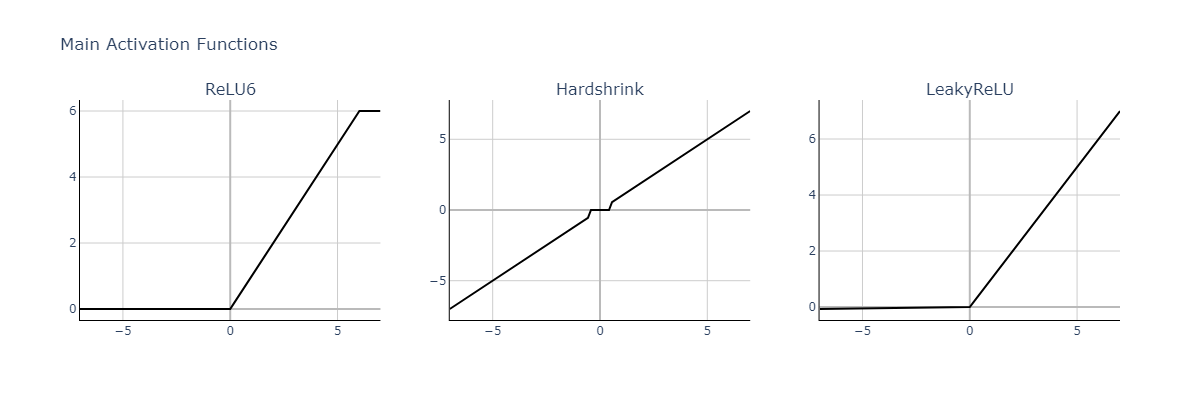

In [21]:
actfun = ['ReLU6', 'Hardshrink', 'LeakyReLU']
x = torch.linspace(-7, 7, 101)

fig = make_subplots(rows=1, cols=3, subplot_titles=actfun)

for i, fun in enumerate(actfun):
    fig.add_trace(go.Scatter(
        x=x, y=NNoutputx(fun)(x), mode='lines', line=dict(color='black'), showlegend=False
    ), row=1, col=i+1)

plotly_main_subplot_layout(fig, title='Main Activation Functions', width=1200, height=400,)

In [22]:
class ANNwine(nn.Module):
    def __init__(self, actfun):
        super().__init__()

        self.input = nn.Linear(11, 16)
        self.fc1 = nn.Linear(16, 32)
        self.fc2 = nn.Linear(32, 20)
        self.output = nn.Linear(20, 1)

        actfun = getattr(nn, actfun)()
        self.actfun = actfun

    def forward(self, x):
        x = self.actfun(self.input(x))
        x = self.actfun(self.fc1(x))
        x = self.actfun(self.fc2(x))
        x = self.output(x)
        return x
    

def trainTheModel(numepochs:int=1000):
    lossfun = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.SGD(widenet.parameters(), lr=0.01)

    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []

    for epochi in range(numepochs):
        widenet.train()
        batchAcc = []
        batchLoss = []

        for X, y in train_loader:
            yHat = widenet(X)
            loss = lossfun(yHat, y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())
            batchAcc.append(100*torch.mean(((yHat > 0) == y).float()).item())

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        widenet.eval()
        X, y = next(iter(test_loader)) 
        with torch.no_grad():
            yHat = widenet(X)
        testAcc.append(100*torch.mean(((yHat > 0) == y).float()).item())
  
    # function output
    return trainAcc, testAcc, losses

In [23]:
act_functions = ['ReLU', 'Sigmoid', 'Tanh', 'ReLU6', 'Hardshrink', 'LeakyReLU']

numepochs = 800
trainByAct = np.zeros((numepochs, len(act_functions)))
testByAct = np.zeros((numepochs, len(act_functions)))

for ai, act_function in enumerate(act_functions):
    widenet = ANNwine(actfun=act_function)
    trainByAct[:,ai], testByAct[:,ai], losses = trainTheModel(numepochs=numepochs)

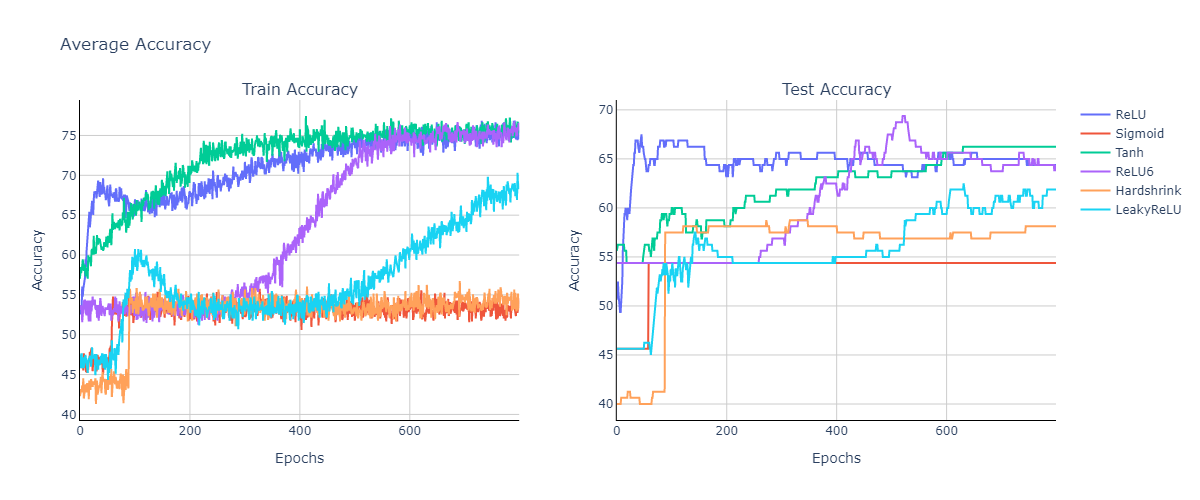

In [24]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['Train Accuracy', 'Test Accuracy'])

colors = plotly_colors.qualitative.Plotly[:len(act_functions)]

for i, (acc_label, color) in enumerate(zip(act_functions, colors)):
    fig.add_trace(go.Scatter(
        x=list(range(numepochs)), y=trainByAct[:, i], 
        name=f'{acc_label}', mode='lines', line=dict(color=color)
    ), row=1, col=1)

# Plot Test Accuracy using same colors
for i, (acc_label, color) in enumerate(zip(act_functions, colors)):
    fig.add_trace(go.Scatter(
        x=list(range(numepochs)), y=testByAct[:, i], 
        name=f'{acc_label}', mode='lines',line=dict(color=color), showlegend=False  
    ), row=1, col=2)

plotly_main_subplot_layout(fig, title='Average Accuracy', x='Epochs', y='Accuracy', width=1200, height=500,)

___
### Loss Functions


- Motivation: 
    - $\hat{y} = \sigma(\textbf{x}^\text{T}\textbf{w})$
    - $\textbf{w} \leftarrow \textbf{w} - \eta d\mathcal{L}$

    
> ##### MSE
> - $\mathcal{L} = \dfrac{1}{2}(\hat{y}-y)^2$
> - Used for continuous data when the output is a numerical prediction
> - Linear activation function

> ##### Cross-Entropy (Logistic or BCE)
> - $\mathcal{L} = -(y\log(\hat{y}) + (1+y)\log(1-\hat{y}))$
> - Used for binary categorical data when the output is a probability
> - Sigmoid activation function

> ##### Log-Likelihood (N-way or CCE)
> - $\mathcal{L} = -\sum_{i=1}^{N}\sum_{k=1}^C = y_i^{(k)} \log(\hat{y}_i^{(k)})$
> - Used for categorical data with one-hot encoding
> - Softmax activation function

> ##### Kullback-Leibler Divergence
> - $\mathcal{L} = -\sum_{z}p(x)\log\left( \dfrac{p(x)}{q(x)} \right)$
> - Measures the "distance" between two probability distributions

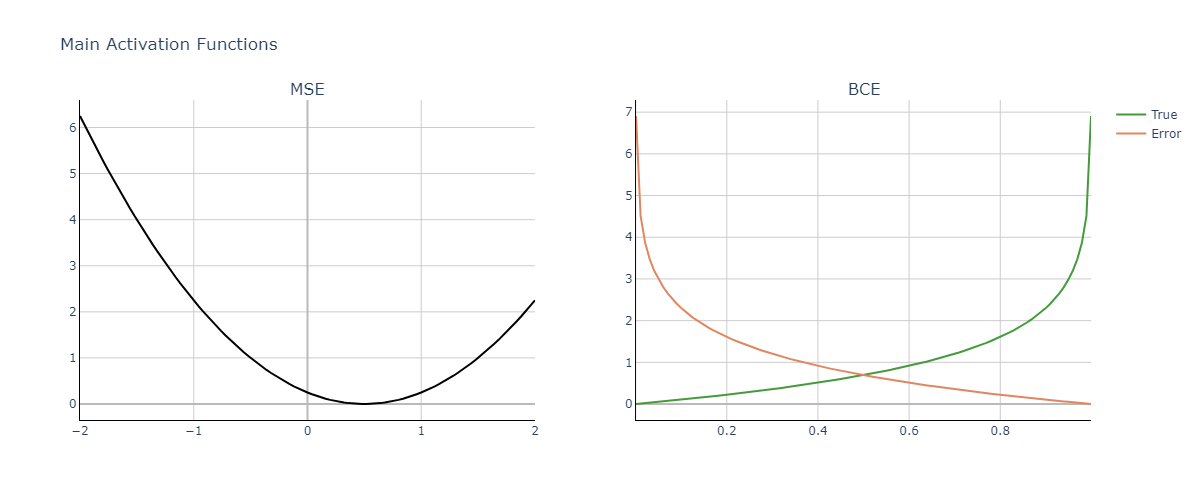

In [25]:
fig = make_subplots(rows=1, cols=2, subplot_titles=['MSE', 'BCE'])

lossfunMSE = nn.MSELoss()
yHat = torch.linspace(-2,2,101)
y = torch.tensor(.5)

L = np.zeros(101)
for i,yy in enumerate(yHat):
  L[i] = lossfunMSE(yy,y)

fig.add_trace(go.Scatter(
    x=yHat, y=L, mode='lines', line=dict(color='black'), showlegend=False
), row=1, col=1)


lossfunBCE = nn.BCELoss()
yHat = torch.linspace(.001,.999,101)
y1 = torch.tensor(0.)
y2 = torch.tensor(1.)

L = np.zeros((101,2))
for i,yy in enumerate(yHat):
  L[i,0] = lossfunBCE(yy,y1)
  L[i,1] = lossfunBCE(yy,y2)

fig.add_trace(go.Scatter(
    x=yHat, y=L[:,0], mode='lines', line=dict(color='#459b3b'), name='True'
), row=1, col=2)
fig.add_trace(go.Scatter(
    x=yHat, y=L[:,1], mode='lines', line=dict(color='#e08761'), name='Error'
), row=1, col=2)

plotly_main_subplot_layout(fig, title='Main Activation Functions', width=1200, height=500,)

In [26]:
class myLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, y):
        loss = torch.abs(x-y)
        return loss

myloss = myLoss()
print(myloss(torch.tensor(4), torch.tensor(5)))

tensor(1)


___
### Optimizers

- Are algorithms that adjusts the weights during backpropagation
- Other optimizers are simply modifications of the SGD

> ##### Stochastic Gradient Descent
> - $\textbf{w} \leftarrow \textbf{w} - \eta d\mathcal{L}$
> - Changes the weights after each sample, being great when all samples are really similar to each other
> - It is very sensible to outliers
>> 
>> ##### Momentum
>> - $v_t = (1-\beta)v_t + \beta v_{t-1}, \quad \beta \in \{ 0, 1 \}$
>> - This smoothes via weighted average
>> - Each data point is a weight combination of itself and the previous data point
>> ##### Mini-Batch SGD
>> - $\textbf{w} \leftarrow \textbf{w} - \eta d\mathcal{J}$
>> - Changes the weights after N samples, avereging the loss achoss those samples
>> - Can be more robust, except when samples are similar to each other
>> ##### SGD Momentum
>> - $\mathbf{v} = (1-\beta) d\mathcal{J} + \beta \mathbf{v}_{t-1}$
>> - $\mathbf{w} \leftarrow \mathbf{w} - \eta\mathbf{v}$
>> - Typical values are $\beta \in [0.9, 0.99]$
>> - Updates the current weights according to a weighted average of current and previous costs
>> - We can understand it as "the direction of the next step is a sum of the current and previous direction"

> ##### RMSprop
> - $\mathbf{s} = (1-\beta) (d\mathcal{J})^2 + \beta \mathbf{s}_{t-1}$
> - $\mathbf{w} \leftarrow \mathbf{w} - \dfrac{\eta}{\sqrt{\mathbf{s}+\epsilon}}d\mathcal{J}$
> - $\epsilon$ is just a term to avoid division by zero
> - Comes from "Root-Mean-Square Propagation"
> - Has a similar concept as momentum, incrementing a bias that weight changes using dampened previus gradients
> - Instead of biasing the gradient, it bias the learning rate according to the magnitude of the gradient
> - The equation is derived from:
>   - $\text{rms} = \sqrt{ \dfrac{1}{n} \sum_{i=1}^n x_i^2 }$
>   - $\text{std} = \sqrt{ \dfrac{1}{n} \sum_{i=1}^n (x_i-\bar{x})^2 }$
> - The step size for adjusting the weight depends on the fistory of the gradient magnitudes (larger gradients = smaller steps, and the opposite also holds) in which large gradients indicates oscillations or volatile learning

> ##### Adam
> - $\mathbf{v} = (1-\beta_1) d\mathcal{J} + \beta_1 \mathbf{v}_{t-1}$
> - $\mathbf{s} = (1-\beta_2) (d\mathcal{J})^2 + \beta_2 \mathbf{s}_{t-1}$
> - $\mathbf{w} \leftarrow \mathbf{w} - \dfrac{\eta}{\sqrt{\tilde{\mathbf{s}}+\epsilon}}\tilde{\mathbf{v}}$
> - The bias correction factors are:
>   - $\tilde{\mathbf{v}} = \dfrac{\mathbf{v}}{1-\beta_1^t}$
>   - $\tilde{\mathbf{s}} = \dfrac{\mathbf{s}}{1-\beta_2^t}$
>   - $t$: epochs
>   - Therefore, at the beginning, powering to $t$ will provide larger values of $\tilde{\mathbf{v}}$ and $\tilde{\mathbf{s}}$ to initiaize training. As epochs progress, this bias starts vanishing
> - Stands for Adaptative Momentum, and it is the combination of momentum and RMSprop, being an extend of SGD
> - The first equations is the momentum and the second is the RMSprop
> - We can say, therefore, that Adam combines the average $d\mathcal{J}$ with the variance $(d\mathcal{J})^2$ of the gradients, adaptively changing the gradient and the learning rate
> - Typical values are $\eta = 0.001$, $\beta_1 = 0.9$, $\beta_2 = 0.999$, and $\epsilon = 10^{-8}$

###### _______________________
#### SGD Momentum

In [34]:
nPerClust = 300
blur = 1

A = [1, 1]
B = [5, 1]
C = [4, 3]

a = [A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur]
b = [B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur]
c = [C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur]

labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))

data_np = np.hstack((a,b,c)).T
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long() 

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(data, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 16
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# create a class for the model
def createTheQwertyNet(momentum):

    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            self.input = nn.Linear(2,8)
            self.fc1 = nn.Linear(8,8)
            self.output = nn.Linear(8,3)


        def forward(self,x):
            x = F.relu( self.input(x) )
            x = F.relu( self.fc1(x) )
            return self.output(x)
            

    net = qwertyNet()
    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=.01, momentum=momentum)

    return net,lossfun,optimizer


def function2trainTheModel(momentum, numepochs:int=50):
    
    net, lossfun, optimizer = createTheQwertyNet(momentum)

    losses   = torch.zeros(numepochs)
    trainAcc = []
    testAcc  = []
    for epochi in range(numepochs):

        net.train()
        batchAcc  = []
        batchLoss = []
        for X,y in train_loader:

            yHat = net(X)
            loss = lossfun(yHat,y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

            matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
            matchesNumeric = matches.float()             # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
            batchAcc.append( accuracyPct )               # add to list of accuracies

        trainAcc.append( np.mean(batchAcc) )
        losses[epochi] = np.mean(batchLoss)

        net.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad(): # deactivates autograd
            yHat = net(X)
        testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) ) 

    return trainAcc, testAcc, losses, net


numepochs = 50
momenta = [0, .5, .9, .95, .999]
results = np.zeros((numepochs,len(momenta), 3))

for idx, mom in enumerate(momenta):
    trainAcc, testAcc, losses, net = function2trainTheModel(mom)
    results[:,idx,0] = losses
    results[:,idx,1] = trainAcc
    results[:,idx,2] = testAcc

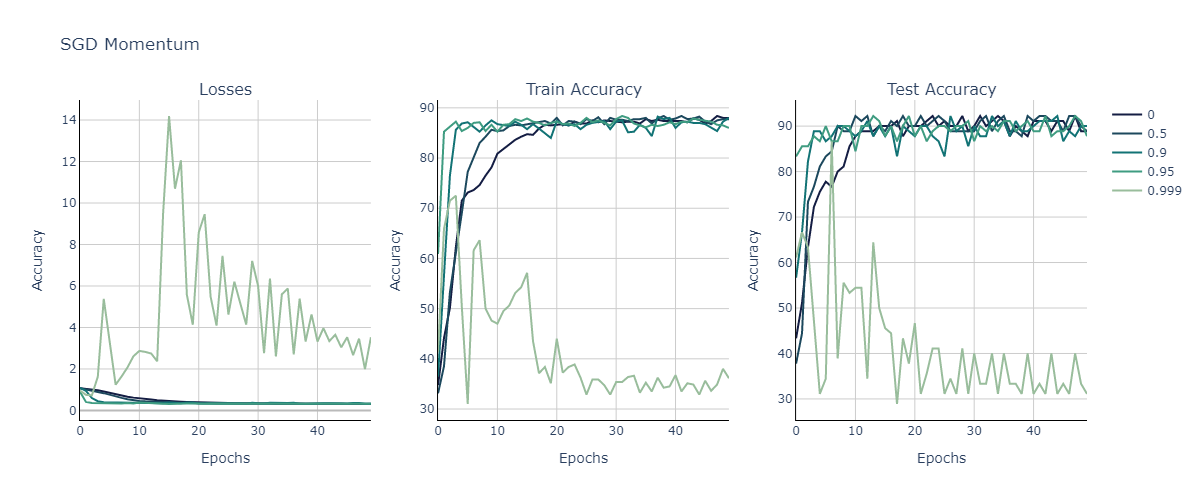

In [53]:
fig = make_subplots(rows=1, cols=3, subplot_titles=['Losses', 'Train Accuracy', 'Test Accuracy'])

colors = plotly_colors.cmocean.curl[:len(momenta)]

# Plot losses
for i, (mom, color) in enumerate(zip(momenta, colors)):
    fig.add_trace(go.Scatter(
        x=list(range(numepochs)), y=results[:,i,0],
        name=f'{mom}', mode='lines', line=dict(color=color)
    ), row=1, col=1)

# Plot Test Accuracy 
for i, (mom, color) in enumerate(zip(momenta, colors)):
    fig.add_trace(go.Scatter(
        x=list(range(numepochs)), y=results[:,i,1], showlegend=False,
        name=f'{mom}', mode='lines', line=dict(color=color)
    ), row=1, col=2)

# Plot Train Accuracy 
for i, (mom, color) in enumerate(zip(momenta, colors)):
    fig.add_trace(go.Scatter(
        x=list(range(numepochs)), y=results[:,i,2], showlegend=False,
        name=f'{mom}', mode='lines', line=dict(color=color)
    ), row=1, col=3)

plotly_main_subplot_layout(fig, title='SGD Momentum', x='Epochs', y='Accuracy', width=1200, height=500)


###### _______________________
#### Optimizers Comparison

In [54]:
def createTheQwertyNet(optimizerAlgo):

    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            self.input = nn.Linear(2,8)
            self.fc1 = nn.Linear(8,8)
            self.output = nn.Linear(8,3)


        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            return self.output(x)
    
    net = qwertyNet()
    lossfun = nn.CrossEntropyLoss()
    optifun = getattr(torch.optim, optimizerAlgo)
    optimizer = optifun(net.parameters(), lr=.01)

    return net, lossfun, optimizer

     
def function2trainTheModel(optimizerType):

    numepochs = 50
    net, lossfun, optimizer = createTheQwertyNet(optimizerType)

    losses   = torch.zeros(numepochs)
    trainAcc = []
    testAcc  = []
    for epochi in range(numepochs):

        net.train()
        batchAcc  = []
        batchLoss = []
        for X,y in train_loader:

            yHat = net(X)
            loss = lossfun(yHat,y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

            matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
            matchesNumeric = matches.float()             # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
            batchAcc.append(accuracyPct )               # add to list of accuracis

        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        net.eval()
        X,y = next(iter(test_loader)) # extract X,y from test dataloader
        with torch.no_grad(): # deactivates autograd
            yHat = net(X)
        
        testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()))

    return trainAcc, testAcc, losses, net

In [78]:
def plotTheResults(optimizerType):

    # compute accuracy over entire dataset (train+test)
    yHat = net(data)
    predictions = torch.argmax(yHat,axis=1)
    accuracy = (predictions == labels).float()
    totalAcc = torch.mean(100*accuracy).item()

    # and accuracy by group
    accuracyByGroup = np.zeros(3)
    for i in range(3):
        accuracyByGroup[i] = 100*torch.mean(accuracy[labels==i])


    fig = make_subplots(rows=2, cols=2)

    fig.add_trace(go.Scatter(
        x=[i for i in range(numepochs)], y=losses.detach(), showlegend=False,
        mode='markers', marker=dict(line=dict(color='#28adc8', width=2), color='white', size=10)
    ), row=1, col=1)

    fig.add_trace(go.Scatter(
        x=[i for i in range(numepochs)], y=trainAcc, name='Train',
        marker=dict(color='white', size=8, line=dict(color='#9c3bbf', width=1)), line=dict(color='#9c3bbf'), mode='markers+lines'
    ), row=1, col=2)
    fig.add_trace(go.Scatter(
        x=[i for i in range(numepochs)], y=testAcc, name='Test',
        marker=dict(color='white', size=8, line=dict(color='#b9bf3b', width=1)), line=dict(color='#b9bf3b'), mode='markers+lines'
    ), row=1, col=2)

    fig.add_trace(go.Bar(
        x=[i for i in range(3)], y=accuracyByGroup, showlegend=False, marker=dict(color='rgba(18, 18, 18, 0.9)')
    ), row=2, col=1)

    color_symbol = [['rgba(63, 156, 233, 0.6)', 'square'], ['rgba(176, 233, 63, 0.6)', 'triangle-up'], ['rgba(90, 71, 179, 0.6)', 'circle']]
    for i in range(3):
        fig.add_trace(go.Scatter(
            x=data[labels==i,0], y=data[labels==i,1], name=f'Group {i}', mode='markers',
            marker=dict(color=color_symbol[i][0], symbol=color_symbol[i][1], size=10)
        ), row=2, col=2)
        idxErr = (accuracy==0) & (labels==i)
        fig.add_trace(go.Scatter(
            x=data[idxErr,0], y=data[idxErr,1], showlegend=False, mode='markers',
            marker=dict(color='rgba(236, 65, 65, 0.8)', symbol='x', size=9)
        ), row=2, col=2)

    plotly_main_subplot_layout(fig, title=f'{optimizerType}', x='Epoch | Group | x', y='Accuracy | y', height=950)
    fig.show()

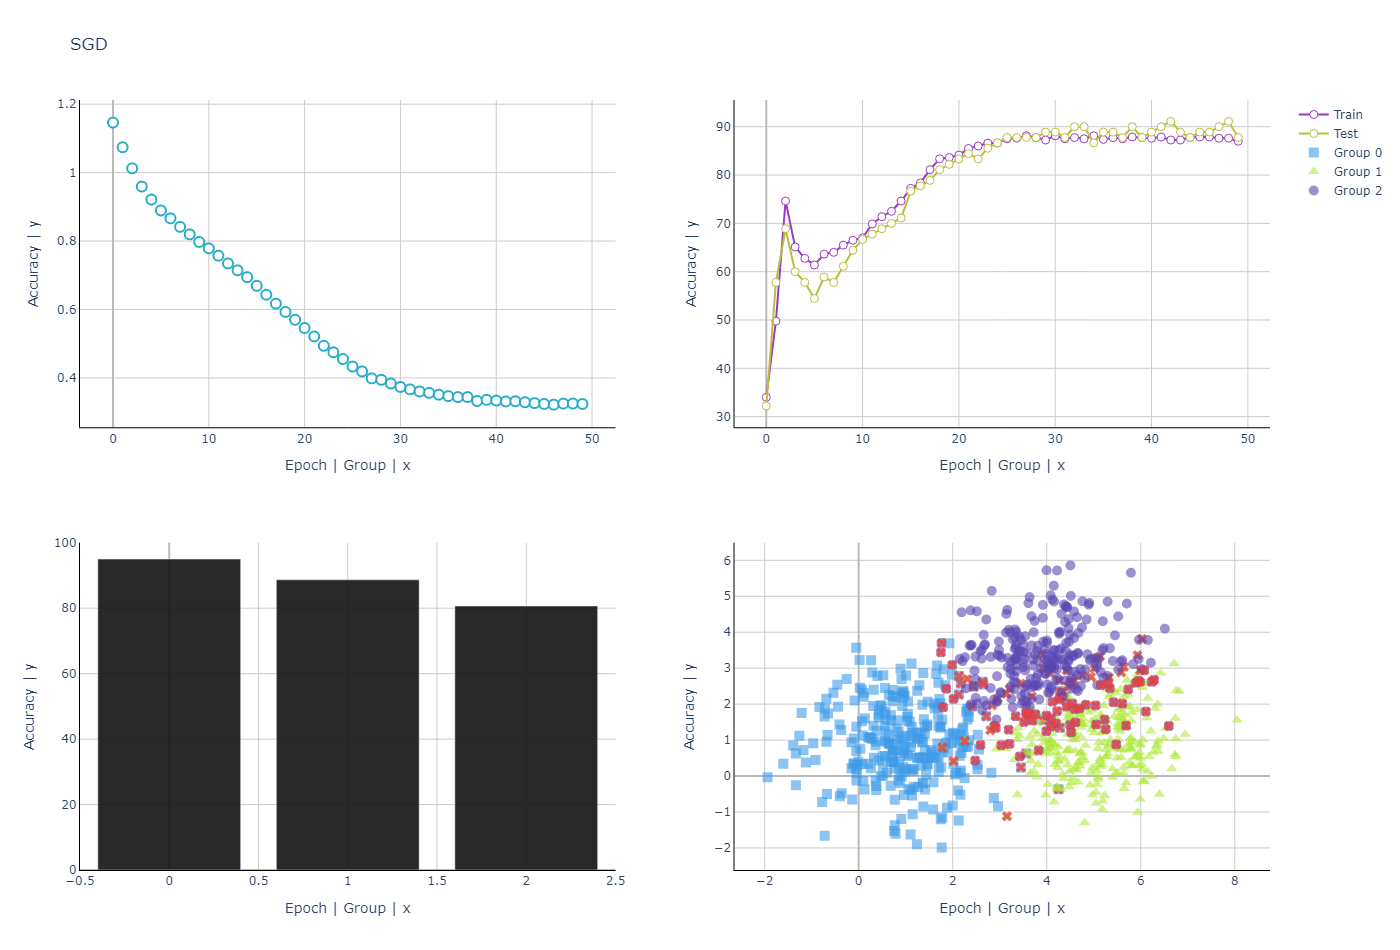

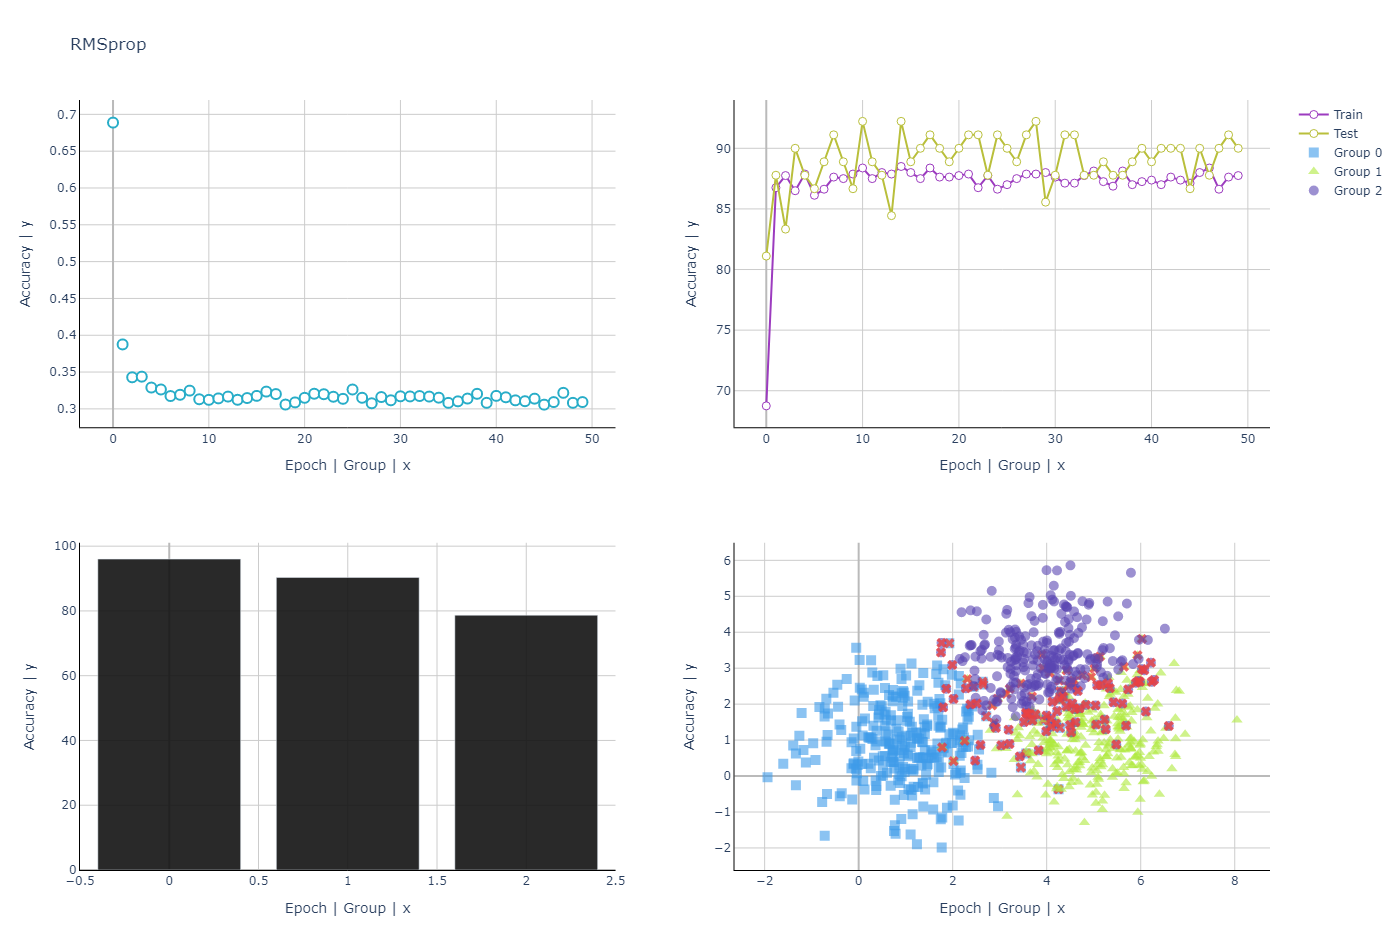

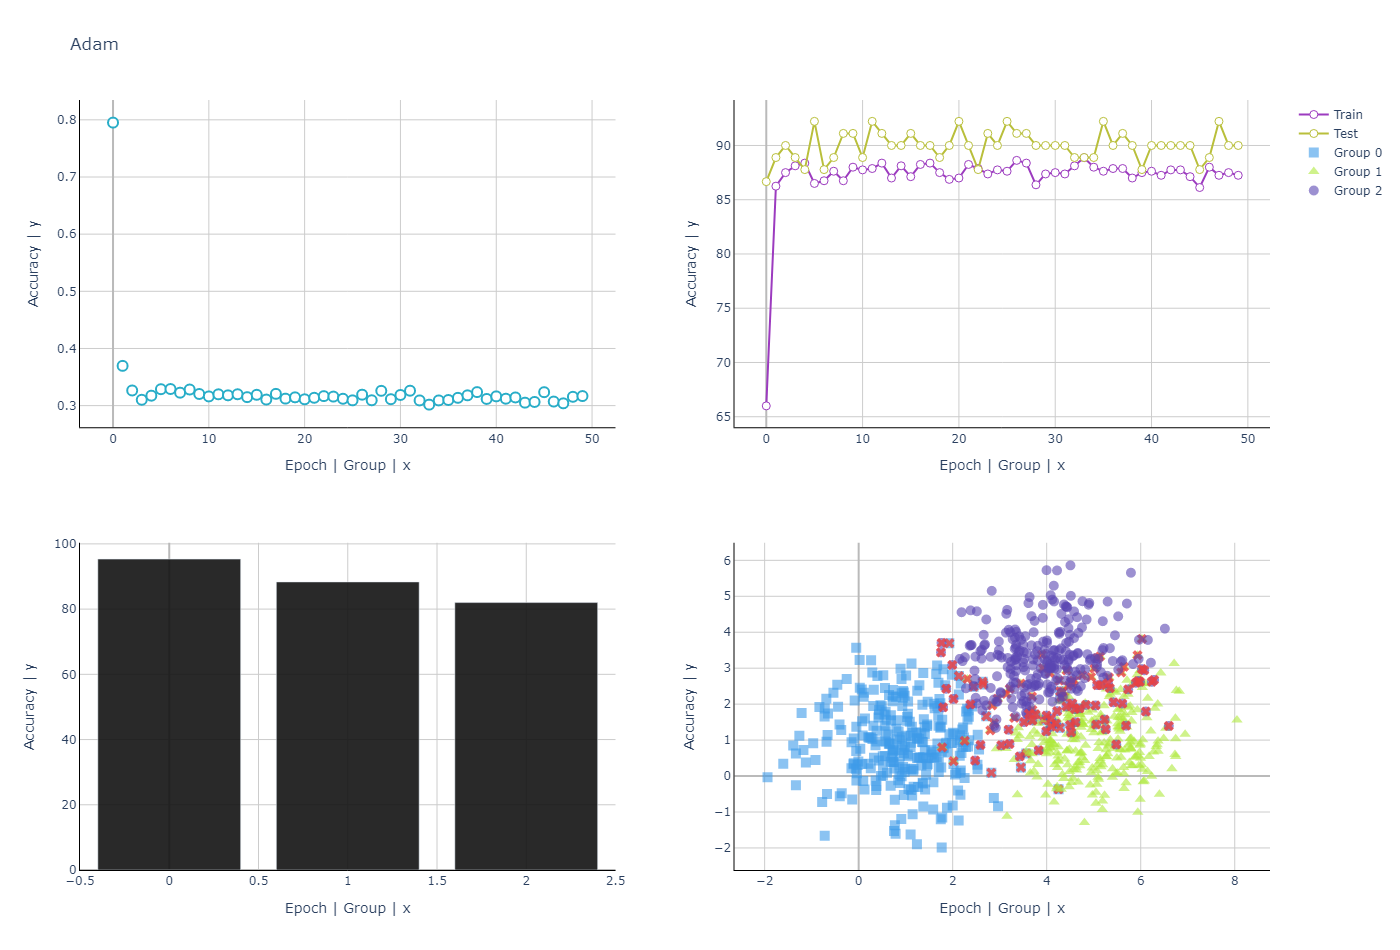

In [79]:
performance = []
for opto in ['SGD', 'RMSprop', 'Adam']:
    trainAcc,testAcc,losses,net = function2trainTheModel(opto)
    plotTheResults(opto)

    # store the final results
    train = np.mean(trainAcc[-10:])
    test  = np.mean(testAcc[-10:])

    performance.append( f'{opto}: train {train:.1f}%, test {test:.1f}%' )

In [83]:
display(performance)

['SGD: train 87.6%, test 89.3%',
 'RMSprop: train 87.5%, test 89.4%',
 'Adam: train 87.4%, test 89.9%']

___
### Learning Rate Decay

In [106]:
def createTheQwertyNet(initialLR):

    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            self.input = nn.Linear(2,8)
            self.fc1 = nn.Linear(8,8)
            self.output = nn.Linear(8,3)


        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            return self.output(x)
    
    net = qwertyNet()
    lossfun = nn.CrossEntropyLoss()

    # optimizer and LR scheduler
    optimizer = torch.optim.SGD(net.parameters(), lr=initialLR)
    stepsize  = batchsize*len(train_loader)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=stepsize, gamma=.5)

    return net, lossfun, optimizer, scheduler
     

len(train_loader)*batchsize
     
net = createTheQwertyNet(.01)[0]
optimizer = torch.optim.SGD(net.parameters(), lr=.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1/2)

for epoch in range(3):
    for batchnum in range(10):
        print(f'Batch {batchnum}, epoch {epoch}: LR={scheduler.get_last_lr()[0]}')
        scheduler.step()


def function2trainTheModel(initialLR,toggleDynamicLR):

    numepochs = 50
    
    net, lossfun, optimizer, scheduler = createTheQwertyNet(initialLR)

    losses    = torch.zeros(numepochs)
    trainAcc  = []
    testAcc   = []
    currentLR = []
    for epochi in range(numepochs):

        net.train()

        batchAcc  = []
        batchLoss = []
        for X, y in train_loader:
            yHat = net(X)
            loss = lossfun(yHat,y)

            if toggleDynamicLR:
                scheduler.step()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchLoss.append(loss.item())

            matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
            matchesNumeric = matches.float()             # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
            batchAcc.append(accuracyPct)                 # add to list of accuracies

            currentLR.append(scheduler.get_last_lr()[0])

        trainAcc.append(np.mean(batchAcc))
        losses[epochi] = np.mean(batchLoss)

        net.eval()
        X, y = next(iter(test_loader)) # extract X, y from test dataloader
        with torch.no_grad(): # deactivates autograd
            yHat = net(X)
        
        testAcc.append(100*torch.mean((torch.argmax(yHat,axis=1) == y).float()))

    return trainAcc, testAcc, losses, net, currentLR

     
trainAcc, testAcc, losses, net, currentLR = function2trainTheModel(.01, False)

Batch 0, epoch 0: LR=0.01
Batch 1, epoch 0: LR=0.01
Batch 2, epoch 0: LR=0.01
Batch 3, epoch 0: LR=0.01
Batch 4, epoch 0: LR=0.01
Batch 5, epoch 0: LR=0.005
Batch 6, epoch 0: LR=0.005
Batch 7, epoch 0: LR=0.005
Batch 8, epoch 0: LR=0.005
Batch 9, epoch 0: LR=0.005
Batch 0, epoch 1: LR=0.0025
Batch 1, epoch 1: LR=0.0025
Batch 2, epoch 1: LR=0.0025
Batch 3, epoch 1: LR=0.0025
Batch 4, epoch 1: LR=0.0025
Batch 5, epoch 1: LR=0.00125
Batch 6, epoch 1: LR=0.00125
Batch 7, epoch 1: LR=0.00125
Batch 8, epoch 1: LR=0.00125
Batch 9, epoch 1: LR=0.00125
Batch 0, epoch 2: LR=0.000625
Batch 1, epoch 2: LR=0.000625
Batch 2, epoch 2: LR=0.000625
Batch 3, epoch 2: LR=0.000625
Batch 4, epoch 2: LR=0.000625
Batch 5, epoch 2: LR=0.0003125
Batch 6, epoch 2: LR=0.0003125
Batch 7, epoch 2: LR=0.0003125
Batch 8, epoch 2: LR=0.0003125
Batch 9, epoch 2: LR=0.0003125


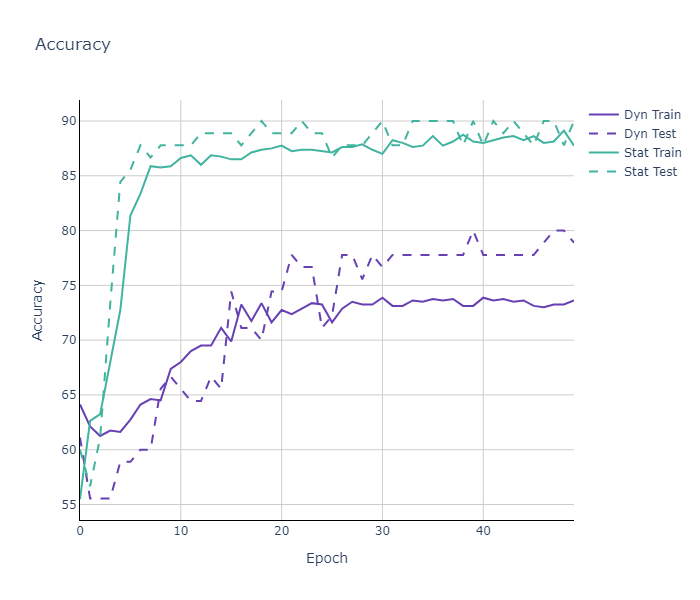

In [117]:
trainAccDynamic, testAccDynamic, losses, net, currentLR = function2trainTheModel(.01, True)
trainAccStatic, testAccStatic, losses, net, currentLR = function2trainTheModel(.01, False)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=[i for i in range(numepochs)], y=trainAccDynamic,
    line=dict(color='#6741b4'), name='Dyn Train'
))
fig.add_trace(go.Scatter(
    x=[i for i in range(numepochs)], y=testAccDynamic,
    line=dict(color='#6741b4', dash='dash'), name='Dyn Test'
))
fig.add_trace(go.Scatter(
    x=[i for i in range(numepochs)], y=trainAccStatic,
    line=dict(color='#41b49f'), name='Stat Train'
))
fig.add_trace(go.Scatter(
    x=[i for i in range(numepochs)], y=testAccStatic,
    line=dict(color='#41b49f', dash='dash'), name='Stat Test'
))
plotly_main_layout(fig, title='Accuracy', x='Epoch', y='Accuracy')